In [1]:
import numpy as np
# from tempfile import TemporaryFile
import os
import pickle
import random 
import operator
import math
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
%%time
import librosa 
import librosa.display

CPU times: user 1.37 s, sys: 834 ms, total: 2.2 s
Wall time: 6min 11s


Gather all features:
* MFCC: https://librosa.org/doc/0.9.1/generated/librosa.feature.mfcc.html#librosa.feature.mfcc
* Spectral Centroid: https://librosa.org/doc/0.9.1/generated/librosa.feature.spectral_centroid.html#librosa.feature.spectral_centroid
* Spectral Bandwidth:https://librosa.org/doc/0.9.1/generated/librosa.feature.spectral_bandwidth.html#librosa.feature.spectral_bandwidth
* Zero Crossing Rate: https://librosa.org/doc/0.9.1/generated/librosa.feature.zero_crossing_rate.html#librosa.feature.zero_crossing_rate
* Spectral Rolloff: https://librosa.org/doc/0.9.1/generated/librosa.feature.spectral_rolloff.html#librosa.feature.spectral_rolloff
* Tempo: https://librosa.org/doc/0.9.1/generated/librosa.beat.tempo.html#librosa.beat.tempo
* Chroma: https://librosa.org/doc/0.9.1/generated/librosa.feature.chroma_stft.html#librosa.feature.chroma_stft
* RMS:https://librosa.org/doc/main/generated/librosa.feature.rms.html
    * reprsents the energy over time (based on spectrogram) since the spectrogram is a far more accurate representation of energy over time than raw time.

In [6]:
x, sr = librosa.load("../data/blues/blues.00000.wav")
onset_env = librosa.onset.onset_strength(y=x, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
tempo        

array([123.046875])

In [7]:
pitches, magnitudes = librosa.piptrack(y=x, sr=sr)
print(pitches)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


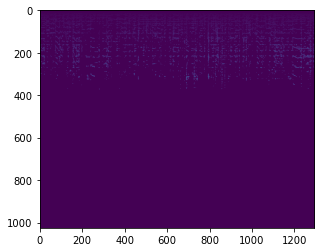

In [13]:
plt.imshow(pitches)

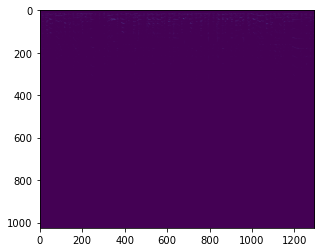

In [14]:
plt.imshow(magnitudes)

In [20]:
librosa.feature.chroma_stft(y=x, sr = sr).var(1).shape

(12,)

In [22]:
%%time
directory = "../data/"
data = []
classes = []
for folder in os.listdir(directory):
    if folder=="mf_files":
        continue
    for file in os.listdir(directory+folder):  
        sig, rate = librosa.load(directory+folder+"/"+file)
        
        # MFCC
        mfcc_feat = librosa.feature.mfcc(y =sig, sr= rate)
        mfcc_mean = mfcc_feat.mean(1)
        mfcc_var = mfcc_feat.var(1)
        
        # Spectral Centroid
        spec_centroid = librosa.feature.spectral_centroid(y= sig, sr = rate)
        spec_centroid_mean = spec_centroid.mean(1)
        spec_centroid_var = spec_centroid.var(1)
        
        # Spectral-Bandwidth
        spec_band = librosa.feature.spectral_bandwidth(y=sig, sr= rate)
        spec_band_mean = spec_band.mean(1)
        spec_band_var = spec_band.var(1)
        
        # Zero-Crossing Rate
        zero_cr = librosa.feature.zero_crossing_rate(sig)
        zero_cr_mean = zero_cr.mean(1)
        zero_cr_var = zero_cr.var(1)
        
        # Spectral-Rolloff
        rolloff = librosa.feature.spectral_rolloff(y = sig, sr = rate)
        rolloff_mean = rolloff.mean(1)
        rolloff_var = rolloff.var(1)
        
        # Tempo
        onset_env = librosa.onset.onset_strength(y=sig, sr=rate)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=rate)
        
        # Chroma
        chroma = librosa.feature.chroma_stft(y=sig, sr = rate)
        chroma_mean = chroma.mean(1) 
        chroma_var = chroma.var(1)
        
        # RMS
        S, phase = librosa.magphase(librosa.stft(sig))
        rms = librosa.feature.rms(S=S)
        rms_mean = rms.mean(1)
        rms_var = rms.var(1)
        
        data.append(np.array([mfcc_mean, mfcc_var,
                             spec_centroid_mean, spec_centroid_var,
                             spec_band_mean, spec_band_var,
                             zero_cr_mean, zero_cr_var,
                             rolloff_mean, rolloff_var,
                             tempo,
                             chroma_mean, chroma_var,
                             rms_mean, rms_var]).flatten())
        classes.append(folder)

<timed exec>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


CPU times: user 33min 40s, sys: 2min 44s, total: 36min 24s
Wall time: 10min 38s


In [34]:
df = np.array([np.array(np.hstack(row)) for row in data])

In [35]:
np.array(df).shape

(1000, 75)

### KNN

0.66
KNeighborsClassifier(n_jobs=-1, n_neighbors=6, weights='distance')
CPU times: user 1.26 s, sys: 574 ms, total: 1.84 s
Wall time: 8.85 s


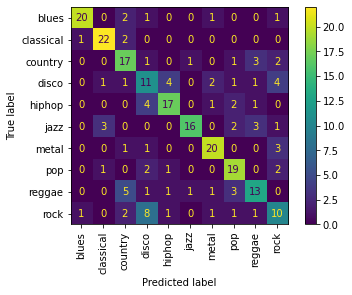

In [36]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
data = df
classes = np.array(classes)
trainX, testX, trainY, testY = train_test_split(data, 
                                                classes,
                                                test_size = 0.25, 
                                                random_state=29,
                                                stratify = classes)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
clf = GridSearchCV(estimator=KNeighborsClassifier(n_jobs = -1), 
                   param_grid = {"n_neighbors" : np.arange(4,30,1),
                               "weights" : ["uniform", "distance"]}, 
                   cv =5, n_jobs = -1)
clf.fit(trainX, trainY)
print(clf.score(testX, testY))
print(clf.best_estimator_)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = testY, y_pred = clf.predict(testX), 
                                        xticks_rotation= "vertical")

### Logistic Regression

0.68
LogisticRegressionCV(max_iter=10000, n_jobs=-1, solver='saga')
CPU times: user 1min 37s, sys: 1.03 s, total: 1min 38s
Wall time: 2min 21s


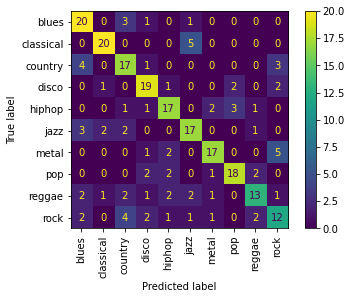

In [37]:
%%time
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
data = df
classes = np.array(classes)
trainX, testX, trainY, testY = train_test_split(data, 
                                                classes,
                                                test_size = 0.25, 
                                                random_state=29,
                                                stratify = classes)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
clf = GridSearchCV(estimator=LogisticRegressionCV(n_jobs = -1, max_iter = 10000), 
                   param_grid = {"solver" : ["saga", "lbfgs"]}, 
                   cv =5, n_jobs = -1)
clf.fit(trainX, trainY)
print(clf.score(testX, testY))
print(clf.best_estimator_)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = testY, y_pred = clf.predict(testX), 
                                        xticks_rotation= "vertical")

### Random Forest

0.7
RandomForestClassifier(max_depth=15, n_estimators=300, n_jobs=-1)
CPU times: user 3.13 s, sys: 334 ms, total: 3.46 s
Wall time: 10min 32s


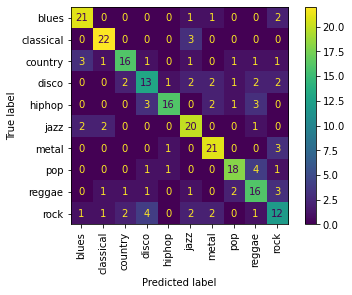

In [38]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
data = df
classes = np.array(classes)
trainX, testX, trainY, testY = train_test_split(data, 
                                                classes,
                                                test_size = 0.25, 
                                                random_state=29,
                                                stratify = classes)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
clf = GridSearchCV(estimator=RandomForestClassifier(n_jobs = -1), 
                   param_grid = {"criterion" : ["gini", "entropy"],
                                 "n_estimators": np.arange(100,501, 100),
                                 "max_depth": np.arange(1,20,1)}, 
                   cv =5, n_jobs = -1)
# clf = RandomForestClassifier()
clf.fit(trainX, trainY)
print(clf.score(testX, testY))
print(clf.best_estimator_)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = testY, y_pred = clf.predict(testX), 
                                        xticks_rotation= "vertical")

### AdaBoost

0.704
AdaBoostClassifier(base_estimator=RandomForestClassifier(),
                   learning_rate=1.8000000000000003, n_estimators=190)
CPU times: user 3.92 s, sys: 377 ms, total: 4.3 s
Wall time: 4min 21s


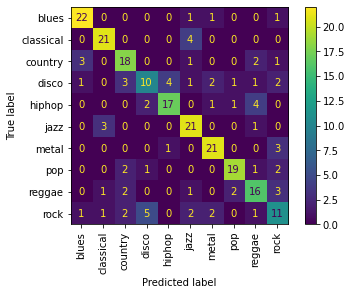

In [39]:
%%time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
data = df
classes = np.array(classes)
trainX, testX, trainY, testY = train_test_split(data, 
                                                classes,
                                                test_size = 0.25, 
                                                random_state=29,
                                                stratify = classes)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
clf = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=RandomForestClassifier()), 
                   param_grid = { "learning_rate": np.arange(0.1,2,.1),
                                 "n_estimators": np.arange(50,300,10)}, 
                   cv =5, n_jobs = -1)
clf.fit(trainX, trainY)
print(clf.score(testX, testY))
print(clf.best_estimator_)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = testY, y_pred = clf.predict(testX), 
                                        xticks_rotation= "vertical")

### Gradient Boost

0.696
GradientBoostingClassifier(learning_rate=0.4, n_estimators=240)
CPU times: user 25.8 s, sys: 234 ms, total: 26 s
Wall time: 1h 8min


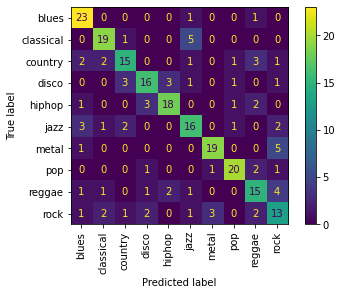

In [40]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
data = df
classes = np.array(classes)
trainX, testX, trainY, testY = train_test_split(data, 
                                                classes,
                                                test_size = 0.25, 
                                                random_state=29,
                                                stratify = classes)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
clf = GridSearchCV(estimator=GradientBoostingClassifier(), 
                   param_grid = { "learning_rate": np.arange(0.1,1,.1),
                                 "n_estimators": np.arange(50,300,10)}, 
                   cv =5, n_jobs = -1)
clf.fit(trainX, trainY)
print(clf.score(testX, testY))
print(clf.best_estimator_)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = testY, y_pred = clf.predict(testX), 
                                        xticks_rotation= "vertical")